In [19]:
# Core imports
import numpy as np
import heyoka as hk
import pykep as pk
import pandas as pd
# Sys imports
import time

# Plot imports
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick

%matplotlib notebook

In [2]:
#constants
GMe = 3.986004407799724e+5 # [km^3/sec^2]
GMo = 1.32712440018e+11 #[km^3/sec^2]
GMm = 4.9028e+3 #[km^3/sec^2]
Re = 6378.1363 #[km]
C20 = -4.84165371736e-4
C22 = 2.43914352398e-6
S22 = -1.40016683654e-6
theta_g = (np.pi/180)*280.4606 #[rad]
nu_e = (np.pi/180)*(4.178074622024230e-3) #[rad/sec]
nu_o = (np.pi/180)*(1.1407410259335311e-5) #[rad/sec]
nu_ma = (np.pi/180)*(1.512151961904581e-4) #[rad/sec]
nu_mp = (np.pi/180)*(1.2893925235125941e-6) #[rad/sec]
nu_ms = (np.pi/180)*(6.128913003523574e-7) #[rad/sec]
alpha_o = 1.49619e+8 #[km]
epsilon = (np.pi/180)*23.4392911 #[rad]
phi_o = (np.pi/180)*357.5256 #[rad]
Omega_plus_w = (np.pi/180)*282.94 #[rad]
PSRP = 4.56e-3 #[kg/(km*sec^2)]

In [3]:
#create heyoka variables
X,Y,Z = hk.make_vars("X","Y","Z")
VX,VY,VZ = hk.make_vars("VX","VY","VZ")

In [4]:
############################# RHS (right hand side of the ODE) setup #############################

#Sun's position
lo = phi_o + nu_o*hk.time
lambda_o = Omega_plus_w + lo + (np.pi/180)*( (6892/3600)*hk.sin(lo) + (72/3600)*hk.sin(2*lo) )
ro = (149.619 - 2.499*hk.cos(lo) - 0.021*hk.cos(2*lo))*(10**6)

Xo = ro*hk.cos(lambda_o)
Yo = ro*hk.sin(lambda_o)*np.cos(epsilon)
Zo = ro*hk.sin(lambda_o)*np.sin(epsilon)

#Moon's position
phi_m = nu_o*hk.time
phi_ma = nu_ma*hk.time
phi_mp = nu_mp*hk.time
phi_ms = nu_ms*hk.time
L0 = phi_mp + phi_ma + (np.pi/180)*218.31617
lm = phi_ma + (np.pi/180)*134.96292
llm = phi_m + (np.pi/180)*357.5256
Fm = phi_mp + phi_ma + phi_ms + (np.pi/180)*93.27283
Dm = phi_mp + phi_ma - phi_m  + (np.pi/180)*297.85027

rm = 385000 - 20905*hk.cos(lm) - 3699*hk.cos(2*Dm - lm) - 2956*hk.cos(2*Dm) - \
     570*hk.cos(2*lm) + 246*hk.cos(2*lm - 2*Dm) - 205*hk.cos(llm - 2*Dm) - \
     171*hk.cos(lm + 2*Dm) - 152*hk.cos(lm + llm - 2*Dm)
     
lambda_m = L0 + (np.pi/180)*( (22640/3600)*hk.sin(lm) + (769/3600)*hk.sin(2*lm) - (4856/3600)*hk.sin(lm - 2*Dm) + \
     (2370/3600)*hk.sin(2*Dm) - (668/3600)*hk.sin(llm) - (412/3600)*hk.sin(2*Fm) - \
     (212/3600)*hk.sin(2*lm - 2*Dm) - (206/3600)*hk.sin(lm + llm - 2*Dm) + \
     (192/3600)*hk.sin(lm + 2*Dm) - (165/3600)*hk.sin(llm - 2*Dm) + \
     (148/3600)*hk.sin(lm - llm) - (125/3600)*hk.sin(Dm) - (110/3600)*hk.sin(lm + llm) - \
     (55/3600)*hk.sin(2*Fm - 2*Dm) )
     
βm = (np.pi/180)*( (18520/3600)*hk.sin(Fm + lambda_m - L0 + (np.pi/180)*((412/3600)*hk.sin(2*Fm) + (541/3600)*hk.sin(llm)) ) - \
     (526/3600)*hk.sin(Fm - 2*Dm) + (44/3600)*hk.sin(lm + Fm - 2*Dm) - (31/3600)*hk.sin(-lm + Fm -2*Dm) - \
     (25/3600)*hk.sin(-2*lm + Fm) - (23/3600)*hk.sin(llm + Fm - 2*Dm) + (21/3600)*hk.sin(-lm + Fm) + \
     (11/3600)*hk.sin(-llm + Fm - 2*Dm) )
     
Xm =  hk.cos(βm)*hk.cos(lambda_m)*rm
Ym = -np.sin(epsilon)*hk.sin(βm)*rm + np.cos(epsilon)*hk.cos(βm)*hk.sin(lambda_m)*rm
Zm =  np.cos(epsilon)*hk.sin(βm)*rm + hk.cos(βm)*np.sin(epsilon)*hk.sin(lambda_m)*rm

#Earth's Keplerian terms
magR2 = X**2 + Y**2 + Z**2
fKepX = -GMe*X/(magR2**(3./2))
fKepY = -GMe*Y/(magR2**(3./2))
fKepZ = -GMe*Z/(magR2**(3./2))

#Earth's J2 terms
J2term1 = GMe*(Re**2)*np.sqrt(5)*C20/(2*magR2**(1./2))
J2term2 = 3/(magR2**2)
J2term3 = 15*(Z**2)/(magR2**3)
fJ2X = J2term1*X*(J2term2 - J2term3)
fJ2Y = J2term1*Y*(J2term2 - J2term3)
fJ2Z = J2term1*Z*(3*J2term2 - J2term3)

#Earth's C22 and S22 terms
x =  X*hk.cos(theta_g + nu_e*hk.time) + Y*hk.sin(theta_g + nu_e*hk.time)
y = -X*hk.sin(theta_g + nu_e*hk.time) + Y*hk.cos(theta_g + nu_e*hk.time)
z = Z
magr2 = x**2 + y**2 + z**2

C22term1 = 5*GMe*(Re**2)*np.sqrt(15)*C22/(2*magr2**(7./2))
C22term2 = GMe*(Re**2)*np.sqrt(15)*C22/(magr2**(5./2))
fC22x = C22term1*x*(y**2 - x**2) + C22term2*x
fC22y = C22term1*y*(y**2 - x**2) - C22term2*y
fC22z = C22term1*z*(y**2 - x**2)

S22term1 = 5*GMe*(Re**2)*np.sqrt(15)*S22/(magr2**(7./2))
S22term2 = GMe*(Re**2)*np.sqrt(15)*S22/(magr2**(5./2))
fS22x = -S22term1*(x**2)*y + S22term2*y
fS22y = -S22term1*x*(y**2) + S22term2*x
fS22z = -S22term1*x*y*z

fC22X = fC22x*hk.cos(theta_g + nu_e*hk.time) - fC22y*hk.sin(theta_g + nu_e*hk.time)
fC22Y = fC22x*hk.sin(theta_g + nu_e*hk.time) + fC22y*hk.cos(theta_g + nu_e*hk.time)
fC22Z = fC22z

fS22X = fS22x*hk.cos(theta_g + nu_e*hk.time) - fS22y*hk.sin(theta_g + nu_e*hk.time)
fS22Y = fS22x*hk.sin(theta_g + nu_e*hk.time) + fS22y*hk.cos(theta_g + nu_e*hk.time)
fS22Z = fS22z

#Sun's gravity
magRo2 = Xo**2 + Yo**2 + Zo**2
magRRo2 = (X - Xo)**2 + (Y - Yo)**2 + (Z - Zo)**2
fSunX = -GMo*( (X - Xo)/(magRRo2**(3./2)) + Xo/(magRo2**(3./2)) )
fSunY = -GMo*( (Y - Yo)/(magRRo2**(3./2)) + Yo/(magRo2**(3./2)) )
fSunZ = -GMo*( (Z - Zo)/(magRRo2**(3./2)) + Zo/(magRo2**(3./2)) )

#Moon's gravity 
magRm2 = Xm**2 + Ym**2 + Zm**2
magRRm2 = (X - Xm)**2 + (Y - Ym)**2 + (Z - Zm)**2
fMoonX = -GMm*( (X - Xm)/(magRRm2**(3./2)) + Xm/(magRm2**(3./2)) )
fMoonY = -GMm*( (Y - Ym)/(magRRm2**(3./2)) + Ym/(magRm2**(3./2)) )
fMoonZ = -GMm*( (Z - Zm)/(magRRm2**(3./2)) + Zm/(magRm2**(3./2)) )

#Sun's radiation pressure (AOM is a heyoka parameter hy.par[0]. We
#will be able to set it later without recompiling the integartor)
SRPterm = hk.par[0]*PSRP*(alpha_o**2)/(magRRo2**(3./2))
fSRPX = SRPterm*(X - Xo)
fSRPY = SRPterm*(Y - Yo)
fSRPZ = SRPterm*(Z - Zo)

############################# end of RHS setup #############################

In [5]:
dXdt = VX
dYdt = VY
dZdt = VZ
dVXdt = fKepX + fJ2X + fC22X + fS22X + fSunX + fMoonX + fSRPX
dVYdt = fKepY + fJ2Y + fC22Y + fS22Y + fSunY + fMoonY + fSRPY
dVZdt = fKepZ + fJ2Z + fC22Z + fS22Z + fSunZ + fMoonZ + fSRPZ

In [6]:
# Step 1: Define Initial Conditions (dimensional)
r0 = np.array([0.0, -5888.9727, -3400.0]) #km   (class 'numpy.ndarray')
v0 = np.array([10.691338, 0.0, 0.0])      #km/s

t0 = 0.0 #[in seconds past the epoch 0]

ic = [*r0, *v0]

print('Compiling the Taylor integrator ... (this is done only once)')
start_time = time.time()

ta = hk.taylor_adaptive(sys = [(X,dXdt),(Y,dYdt),(Z,dZdt),(VX,dVXdt),(VY,dVYdt),(VZ,dVZdt)],
                        state = ic,
                        time = t0,
                        tol = 1e-16,
                        compact_mode = True)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))
print("\nHeyoka Taylor integrator:\n", ta)


Compiling the Taylor integrator ... (this is done only once)
Done, in
--- 3.108064889907837 seconds ---

Heyoka Taylor integrator:
 Taylor order            : 20
Dimension               : 6
Time                    : 0.0000000000000000
State                   : [0.0000000000000000, -5888.9727000000003, -3400.0000000000000, 10.691338000000000, 0.0000000000000000, 0.0000000000000000]
Parameters              : [0.0000000000000000]



In [9]:
# Here we redefine the initial conditions since we may want to change them without recompiling the integrator
ta.time = t0
# Note the python syntax to assign directly the array elements. Here necessary
# as heyoka does not allow to change the memory location of the state
ta.state[:] =  [*r0, *v0]

In [10]:
# Final time
n_orb = 50
# tf = T * n_orb
m = 500
N = n_orb * m
tf = 288.12768941*24*3600 #actual
t_span = np.linspace(t0, tf, N, endpoint = True)
print(np.shape(t_span), N)

(25000,) 25000


In [11]:
start_time = time.time()
out = ta.propagate_grid(t_span)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))
St = out[4] 
size = np.shape(St)
print(f'the shape of the solution (cartesian form) is {size}')

Done, in
--- 0.20501923561096191 seconds ---
the shape of the solution (cartesian form) is (25000, 6)


In [23]:
r = St[:, :3]
v = St[:, -3:]
print(r[-1], v[-1])

print("norm r:", (r[-1][0]**2 + r[-1][1]**2 + r[-1][2]**2)**0.5)
print("norm v:", (v[-1][0]**2 + v[-1][1]**2 + v[-1][2]**2)**0.5)

dim1 = np.shape(t_span)[0]
t_days = np.empty((dim1, 1))

for t, i in zip(t_span, range(dim1)):
    t_days[i, 0] = t/(24*3600)
    
print(t_days[-1]) # 288.8532812 (same as odeint)

[-32941.48949738 231193.80825631  98463.73514897] [-0.30405608 -0.11086204 -0.26352659]
norm r: 253438.01184085695
norm v: 0.41735686860454857
[288.12768941]


              x             y            z
0      0.000000  -5888.972700 -3400.000000
1   9183.362738  -3101.732313 -1786.940950
2  14859.621750   1561.464896   910.010098
3  18679.538838   6129.198080  3550.808856
4  21536.711171  10403.124754  6021.302907


<IPython.core.display.Javascript object>


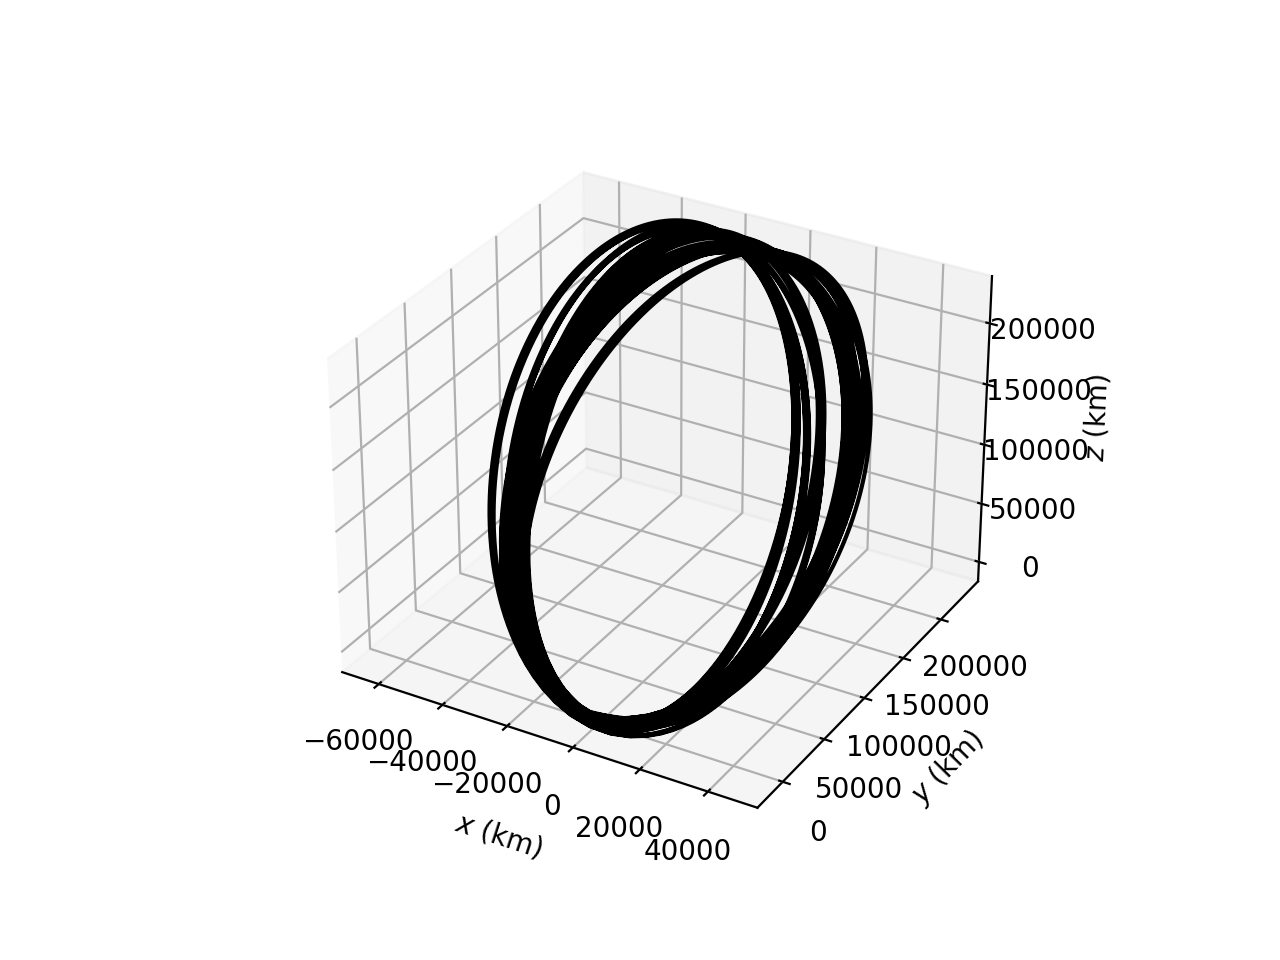

<IPython.core.display.Javascript object>


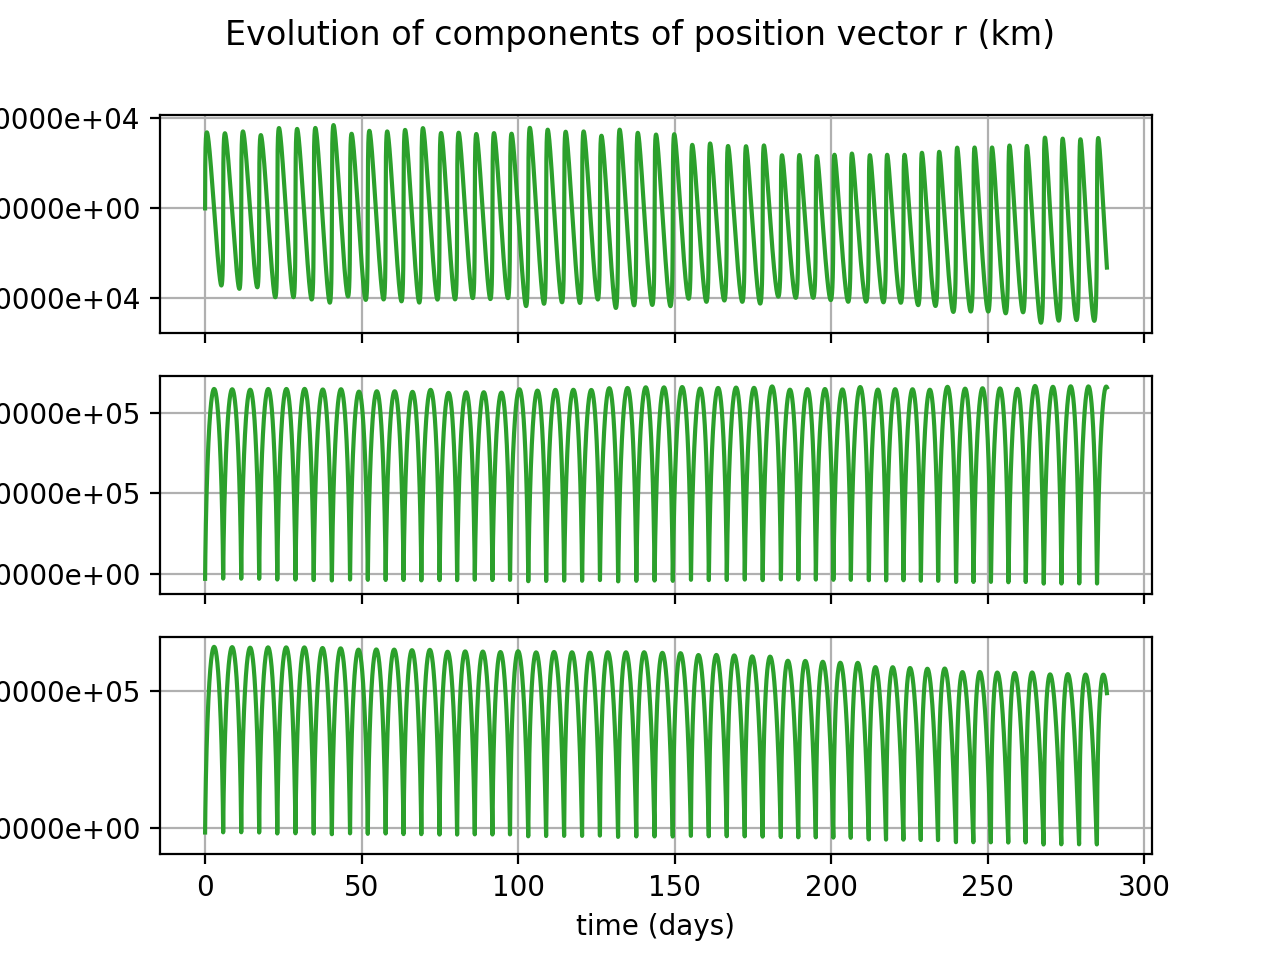

In [22]:
df_pos = pd.DataFrame(r, columns=["x", "y", "z"])
print(df_pos.head())

    
ax = plt.axes(projection='3d')
ax.plot3D(df_pos["x"], df_pos["y"], df_pos["y"], color = 'k', label = 'orbit')
ax.set_aspect('auto')
ax.set(xlabel=r"$x$ (km)", ylabel=r"$y$ (km)", zlabel=r"$z$ (km)")
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig.suptitle(r'Evolution of components of position vector r (km)')
ax1.plot(t_days, df_pos["x"], 'tab:green')
ax1.set(ylabel=r"$x$ (km)")
ax2.plot(t_days, df_pos["y"], 'tab:green')
ax2.set(ylabel=r"$y$ (km)")
ax3.plot(t_days, df_pos["z"], 'tab:green')
ax3.set(xlabel=r"time (days)", ylabel=r"$z$ (km)")
# Add a grid to subplots
ax1.grid()
ax2.grid()
ax3.grid()
# Reformat the y axis notation
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
plt.show()